# **Libraries import**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
import time
from scipy import stats
import random
from contextlib import redirect_stdout

In [ ]:
#da installare una volta per la grafica
!pip install customtkinter --upgrade


# **Data loading** 

In [ ]:
def data_extraction(file_path):
    try:
        data = pd.read_csv(file_path)
        if not file_path.endswith('.csv'):
            raise ValueError('Input file is not a CSV')
        if data.shape[1] != 180:
            raise ValueError(f'Expected 180 columns, got {data.shape[1]}')
        if data.columns[-1] != 'y':
            raise ValueError(f"Last column must be named 'y', got {data.columns[-1]} instead")
        data.drop('Unnamed: 0', axis=1, inplace=True)
        data['Seizure'] = data['y'].apply(lambda x: 1 if x == 1 else 0)
        data.drop('y', axis=1, inplace=True)
        
        scaler = StandardScaler()
        data_norm = scaler.fit_transform(data.iloc[:,:-1])
        mean = np.mean(data_norm)
        var = np.var(data_norm)
        
        return {'status': 'success, data correctly loaded and normalized', 'data': data, 'data_norm' : data_norm,'bol':data.shape[0]==1}
    
    except Exception as e:
        return {'status': 'failure', 'error': str(e),'bol':False}

In [ ]:
#single row file import
single_row1=pd.read_csv("single_row1.csv")
single_row1

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,1


# **EEG PLOT**


In [ ]:
def plot_data_by_seizure(data, unique_labels):
    figs = []
    for i, label in enumerate(unique_labels):
        fig, ax = plt.subplots(figsize = (8,3))
        idx = np.where(data['Seizure'] == label)[0][0]
        ax.plot(data.iloc[idx, :-1])
        if label == 0:
            ax.set_title('No seizure')
        else:
            ax.set_title('Seizure')
        ax.set_xticks(range(0, len(data.columns) - 1, 10))  
        figs.append(fig)
    return figs

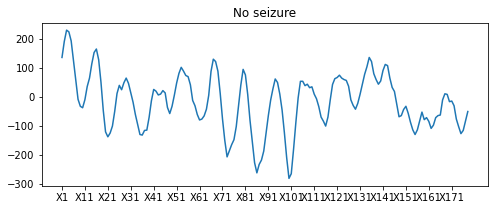

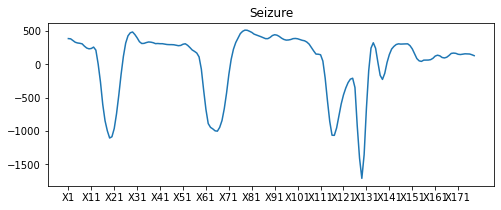

In [ ]:
unique_labels = data['Seizure'].unique()
figsss = plot_data_by_seizure(data, unique_labels)

for i, fig in enumerate(figsss):
    fig.savefig(f'plot_{i}.png')

[<Figure size 576x216 with 1 Axes>, <Figure size 576x216 with 1 Axes>]

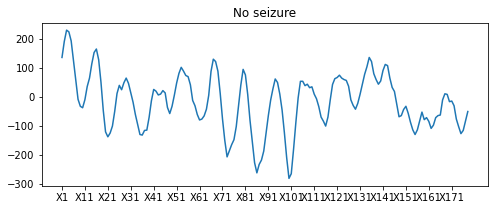

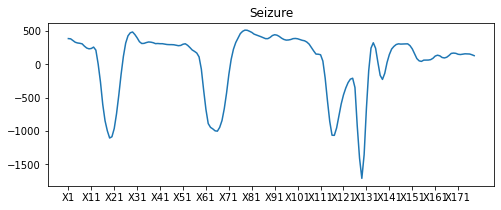

In [ ]:
plot_data_by_seizure(data, [0,1])

# **Hyperparameter tuning and Models training**

In [ ]:
def train_and_evaluate_models(data, data_norm, metric='accuracy'):
    X_train, X_test, y_train, y_test = train_test_split(data_norm, data['Seizure'], test_size=0.2, random_state=42)

    svm_param_grid = {'kernel': ['poly', 'rbf'], 'C': [1, 10], 'degree': [2, 3]}
    rf_param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}

    svm_search = GridSearchCV(SVC(probability=True), svm_param_grid, scoring=metric, n_jobs=-1)
    svm_search.fit(X_train, y_train)

    rf_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, scoring=metric, n_jobs=-1)
    rf_search.fit(X_train, y_train)

    best_svm_params = svm_search.best_params_
    best_rf_params = rf_search.best_params_

    svm = SVC(probability=True, **best_svm_params)
    rf = RandomForestClassifier(**best_rf_params)

    svm.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    best_model = None
    best_score = 0

    for model in [svm, rf]:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        model_metrics = {'Model': model.__class__.__name__,
                         'Best parameters': model.get_params(),
                         'Accuracy': accuracy_score(y_test, y_pred),
                         'Sensitivity': recall_score(y_test, y_pred),
                         'Specificity': recall_score(y_test, y_pred, pos_label=0)}

        if metric == 'accuracy':
            score = model_metrics['Accuracy']
        elif metric == 'sensitivity':
            score = model_metrics['Sensitivity']
        elif metric == 'specificity':
            score = model_metrics['Specificity']
        else:
            raise ValueError('Invalid metric specified!')

        if score > best_score:
            best_score = score
            best_model = (model_metrics, model)
    #print(best_model)

        # Plot comparison between best parameters for SVM and random forest
    svm_metrics = [best_model[0]['Accuracy'], best_model[0]['Sensitivity'], best_model[0]['Specificity']]
    rf_metrics = [rf_search.best_score_, recall_score(y_test, rf.predict(X_test)), recall_score(y_test, rf.predict(X_test), pos_label=0)]
    bar_width = 0.30
    index = np.arange(len(svm_metrics))
    fig1, ax1 = plt.subplots(figsize=(14,8))
    ax1.set_yticks([0.76, 0.80, 0.84, 0.88, 0.92, 0.96, 1.00])
    ax1.set_aspect('equal')
    ax1.bar(index, svm_metrics, bar_width, label='SVM')
    ax1.bar(index + bar_width, rf_metrics, bar_width, label='RFM')
    ax1.set_xlabel('Metric')
    ax1.set_ylabel('Score')
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(('Accuracy', 'Sensitivity', 'Specificity'))
    ax1.set_ylim(0.76, 1.00)
    ax1.legend(loc='lower right')
    ax1.grid(True)
    plt.savefig('mio_plot1.png')
    p1='mio_plot1a.png'
    #p2='mio_plot2.png'
    
    # Get accuracy scores of all SVM and RF models
    svm_accs = svm_search.cv_results_['mean_test_score']
    rf_accs = rf_search.cv_results_['mean_test_score']



    
    #return list(best_model[0]['Best parameters'].items()), fig1
    return [best_model[0]['Model'], best_model[0]['Best parameters'], best_model[1], fig1, svm_metrics[0], rf_metrics[0], svm_accs, rf_accs] #indice 0 nomebestmodel, idx1bestmodelparams,idx2 ilbestmodel, idx3 fig
    #return best_model, fig1
'''
    # Plot comparison between each parameter configuration for SVM and random forest
    svm_scores = []
    rf_scores = []
    for i in range(len(svm_search.cv_results_['params'])):
        svm_scores.append(svm_search.cv_results_['mean_test_score'][i])
    for i in range(len(rf_search.cv_results_['params'])):
        rf_scores.append(rf_search.cv_results_['mean_test_score'][i])
    fig2, ax2 = plt.subplots()
    ax2.plot(svm_scores, label='SVM')
    ax2.plot(rf_scores, label='Random Forest')
    ax2.set_xlabel('Parameter Configuration')
    ax2.set_ylabel('Score')
    ax2.set_xticks(np.arange(len(svm_scores)))
    ax2.set_xticklabels(np.arange(1, len(svm_scores) + 1))
    ax2.legend()
    #plt.savefig('mio_plot2.png')
'''



"\n    # Plot comparison between each parameter configuration for SVM and random forest\n    svm_scores = []\n    rf_scores = []\n    for i in range(len(svm_search.cv_results_['params'])):\n        svm_scores.append(svm_search.cv_results_['mean_test_score'][i])\n    for i in range(len(rf_search.cv_results_['params'])):\n        rf_scores.append(rf_search.cv_results_['mean_test_score'][i])\n    fig2, ax2 = plt.subplots()\n    ax2.plot(svm_scores, label='SVM')\n    ax2.plot(rf_scores, label='Random Forest')\n    ax2.set_xlabel('Parameter Configuration')\n    ax2.set_ylabel('Score')\n    ax2.set_xticks(np.arange(len(svm_scores)))\n    ax2.set_xticklabels(np.arange(1, len(svm_scores) + 1))\n    ax2.legend()\n    #plt.savefig('mio_plot2.png')\n"

# **Models performance evaluation**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def train_svm_with_pca(data_norm, data, svm_params):
    
    X_norm = data_norm[:, :-1]
    y = data['Seizure']

    
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_norm)

    
    svm = SVC(**dict(svm_params))

    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kfold.split(X_pca):
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        svm.fit(X_train, y_train)

    return svm, pca


In [ ]:
def predict_with_trained_svm(svm, pca, data_norm, data, num_rows=1):
    if num_rows == 1:
        # predict a single random row
        idx = data.sample().index[0]
        row = data.loc[idx]
        X_test_norm = data_norm[idx, :-1].reshape(1, -1)
        X_test = pca.transform(X_test_norm)
        y_true = row['Seizure']
        y_pred = svm.predict(X_test)
        proba = svm.predict_proba(X_test)
        
        # plot the row
        plt.figure()
        plt.plot(row.iloc[:-1])
        plt.xticks([])
        plt.title(f"Patient {idx}")
        plt.show()

        print(f"Prediction={y_pred[0]}, Ground Truth={y_true}, Probability={proba[0][y_pred][0]:.2f}")
    else:
        # predict multiple random rows
        random_rows = data.sample(num_rows)
        for i, idx in enumerate(random_rows.index):
            row = data.loc[idx]
            X_test_norm = data_norm[idx, :-1].reshape(1, -1)
            X_test = pca.transform(X_test_norm)
            y_true = row['Seizure']
            y_pred = svm.predict(X_test)
            proba = svm.predict_proba(X_test)
            
            # plot the row
            plt.figure()
            plt.plot(row.iloc[:-1])
            plt.xticks([])
            plt.title(f"Patient {idx}")
            plt.show()

            print(f"Row {i+1}: Prediction={y_pred[0]}, Ground Truth={y_true}, Probability={proba[0][y_pred][0]:.2f}")

predict for single patient by inserting his ID: (N.B. RUN svm,pca=

In [ ]:
import io
import sys
from matplotlib.figure import Figure
def ppredict_with_trained_svm(svm, pca, data_norm, data, num_rows, num):
    output = io.StringIO()
    sys.stdout = output
    
    fig = None
    if num_rows == 1:
        # predict a single specified row
        idx = num
        row = data.loc[idx]
        X_test_norm = data_norm[idx, :-1].reshape(1, -1)
        X_test = pca.transform(X_test_norm)
        y_true = row['Seizure']
        y_pred = svm.predict(X_test)
        proba = svm.predict_proba(X_test)
        
        fig = Figure(figsize=(6, 4), dpi=100)
        ax = fig.add_subplot(111)
        ax.plot(row.iloc[:-1])
        ax.set_xticks([])
        ax.set_title(f"Patient {idx}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
        ax.set_xticks(range(0, 181, 10))

        #print(f"Prediction={y_pred[0]}, Ground Truth={y_true}, Probability={proba[0][int(y_pred)]:.2f}")
        
        if y_pred[0] == 1:
            print(f"The patient with ID {idx} has a probability of {proba[0][int(y_pred)]*100-1:.0f}% of suffering from epilepsy: further controls are suggested")
        else:
            print(f"The patient with ID {idx} has a probability of {proba[0][int(y_pred)]*100-1:.0f}% of NOT suffering from epilepsy: NO further controls are suggested")
            
    sys.stdout = sys.__stdout__
    return fig, output.getvalue()

In [ ]:
# real-time predictions
def real_time_scan(data):
    plot_window = tk.Toplevel(root)
    plot_window.title("Real-time Scan 10sec")
    
    fig, ax = plt.subplots()
    canvas = FigureCanvasTkAgg(fig, master=plot_window)
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    
    seizure_detected = 0
    
    rows = random.sample(range(len(data)), 10)
    #for i in range(10):
    for i in rows:
        row = data.iloc[i, :-1]
        ax.clear()
        ax.plot(row)
        #ax.set_title(f"Row{i+1}")
        if data.iloc[i, -1] == 1:
            seizure_detected +=1
            ax.set_title("SEIZURE DETECTED")
            
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
        ax.set_xticks(range(0, 181, 10))
        
        if data.iloc[i, -1] == 1:
            #seizure_detected +=1
            ax.text(0.5, 0.8, "SEIZURE DETECTED", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,weight='bold')
        
        canvas.draw()
        plot_window.update()
        time.sleep(1.0)
        
        ax.clear()
        canvas.draw()
        plot_window.update()
        time.sleep(0.2)
        
    if seizure_detected>0:
        messagebox.showinfo("ALERT", f"{seizure_detected} Seizures detected, further controls are suggested")
    else:
        messagebox.showinfo("NO SEIZURE DETECTED", f"{seizure_detected} Seizures detected, no further controls are suggested")

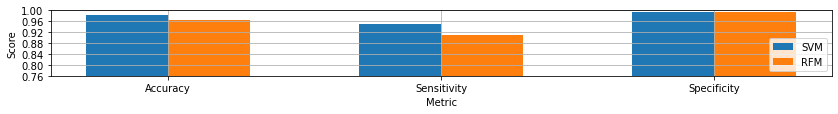

In [ ]:
name_best_model,params, best_model, p1, svm_acc, rf_acc, svm_accs, rf_accs = train_and_evaluate_models(data, data_norm, metric='accuracy')

In [ ]:
params

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

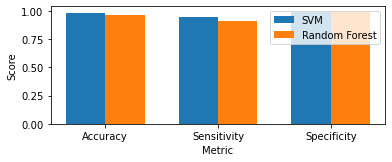

In [ ]:
#sarà l'img di compare models
p1

In [ ]:
best_model

SVC(C=10, degree=2, probability=True)

In [ ]:
name_best_model

'SVC'

In [ ]:
#singole accuracy dei migliori modelli
svm_acc, rf_acc

(0.9830434782608696, 0.9669565217391304)

In [ ]:
svm_accs

array([0.95978261, 0.96858696, 0.86      , 0.96858696, 0.96826087,
       0.9751087 , 0.87782609, 0.9751087 ])

In [ ]:
compare_models(svm_accs,rf_accs)


t-statistic:  -0.7812355755138436
p-value:  0.4527622555243187
The performance difference between the two models is NOT statistically significant.


In [ ]:
svm, pca = train_svm_with_pca(data_norm, data, params)

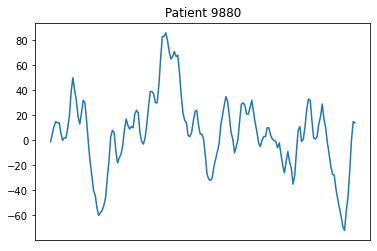

Prediction=0, Ground Truth=0, Probability=1.00


In [ ]:
predict_with_trained_svm(svm, pca, data_norm,data, 1)


# **T-test**

In [ ]:
def compare_models(svm_accs, rf_accs):
    t_stat, p_val = stats.ttest_ind(svm_accs, rf_accs, equal_var=True)
    print("")
    print("t-statistic: ", t_stat)
    print("p-value: ", p_val)
    if p_val < 0.05:
        print("The performance difference between the two models is statistically significant.")
    else:
        print("The performance difference between the two models is NOT statistically significant.")


plot_data_by_seizure(data, [0,1])

best_model


# GUI functions 

In [ ]:
import tkinter as tk
from tkinter import Tk, Frame
from tkinter import filedialog, Label
from tkinter import ttk
from tkinter import Canvas
from tkinter.ttk import Style#, Button
from tkinter import Button
from tkinter import messagebox
import customtkinter as ct
import csv
import os
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from threading import Thread
from queue import Queue
from PIL import ImageTk, Image
from io import StringIO
import sys

def open_pdf():
    os.startfile('file.pdf')
    
def open_inf():
    os.startfile('inf_consent.pdf')

def submit():
    patient_id = int(entry.get())
    figureID, textID = ppredict_with_trained_svm(svm, pca, data_norm, data, 1, patient_id)
    result_window = tk.Toplevel(root)
    result_window.title("Results")
    
    # Visualizza il grafico nella nuova finestra utilizzando un widget Canvas
    canvas = FigureCanvasTkAgg(figureID, master=result_window)
    canvas.draw()
    canvas.get_tk_widget().pack()
        
    result_label = tk.Label(result_window, text=textID)
    result_label.pack()

#import da GUI
def import_dataset():
    global data, data_norm
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    result = data_extraction(file_path)
    if result['status'] == 'failure':
        dataset_label.configure(text=f"Dataset: {os.path.basename(file_path)}\nStatus: {result['status']}\nError: {result['error']}")
    else:
        dataset_label.configure(text=f"Dataset: {os.path.basename(file_path)}\nStatus: {result['status']}")
        data = result['data']
        data_norm=result['data_norm']
        #plot_button.config(state="normal")
        run_button.configure(state="normal")
        compare_button.configure(state="normal")
        real_time_prediction_button.configure(state="normal")
    if result['bol']==False:
        single_prediction_button.configure(state="normal")
        real_time_prediction_button.configure(state="normal")
    else:
        single_prediction_button.configure(state="normal")
        real_time_prediction_button.configure(state="normal")

#plot dei seizure 
def on_plot_click():
    global canvases
    if plot_button.cget("text") == "Show examples":
        unique_labels = data['Seizure'].unique()
        figs = plot_data_by_seizure(data, unique_labels)
        plot_window = tk.Toplevel(root)
        plot_window.title("Plots")
        for fig in figs:
            canvas = FigureCanvasTkAgg(fig, master=plot_window)
            canvas.draw()
            canvas.get_tk_widget().pack()
            canvases.append(canvas)
        #plot_button.configure(text="Hide plots")
    else:
        for canvas in canvases:
            canvas.get_tk_widget().pack_forget()
        canvases.clear()
        #plot_button.configure(text="Show plot")
        
canvases = []        
#plot train
def on_compare_click():
    plot_window = tk.Toplevel(root)
    plot_window.title("Plots")
    plot_window.geometry("1500x900")
    
    # Create two separate Label widgets
    best_model_label = ttk.Label(plot_window, text="Best model: ", font=("TkDefaultFont", 24, "bold"))
    best_model_label.pack(side="top")
    
    model_name_label = ttk.Label(plot_window, text=name_best_model)
    model_name_label.pack(side="top")
                          
    #output_text = f"Best model: {name_best_model}\n\n"
    #output_text += f"Best parameters:\n"
    best_params_label = ttk.Label(plot_window, text="Best parameters:", font=("TkDefaultFont", 24, "bold"))
    best_params_label.pack(side="top")
    output_text=""

    for param, value in params.items():
        output_text += f"  {param}: {value}\n"
        
    output_label=ttk.Label(plot_window, text=output_text)
    output_label.pack()
        
    ttest_label = ttk.Label(plot_window, text="T-TEST", font=("TkDefaultFont", 24, "bold"))
    ttest_label.pack(side="top")
        
    # Call compare_models function and capture its output
    comparison_output=""
    with io.StringIO() as buf, redirect_stdout(buf):
        compare_models(svm_accs, rf_accs)
        comparison_output = buf.getvalue()
    
    # Add comparison_output to output_text
    #comparison_output += "\n" + comparison_output
    
    
    comp_label=ttk.Label(plot_window, text=comparison_output)
    comp_label.pack()
        
    plot_frame = tk.Frame(plot_window, width=400, height=500)
    plot_frame.pack()
    canvas = FigureCanvasTkAgg(p1, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

def train_and_evaluate():
    data_extraction(file_path)
    
    train_and_evaluate_models(data, data_norm, metric='accuracy')
    result_train=train_and_evaluate_models(data, data_norm, metric='accuracy')
    
    # Create a new figure and add a subplot
    fig = Figure(figsize=(5, 4), dpi=100)
    ax = fig.add_subplot(111)
   
    # Create a new canvas and draw the figure on it
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    
    # Pack the canvas on the GUI
    canvas.get_tk_widget().pack()
    
    # Display the return value of the function on the GUI QUAAAAAAAAA
    result_label.configure(text=str(result))

def single_prediction():
    figureID, textID = ppredict_with_trained_svm(svm, pca, data_norm, data, 1, 0)
    result_window = tk.Toplevel(root)
    result_window.title("Single prediction results")
    
    # Visualizza il grafico nella nuova finestra utilizzando un widget Canvas
    canvas = FigureCanvasTkAgg(figureID, master=result_window)
    canvas.draw()
    canvas.get_tk_widget().pack()
        
    result_label = tk.Label(result_window, text=textID)
    result_label.pack()

    
def realtime_prediction():
    real_time_scan(data)


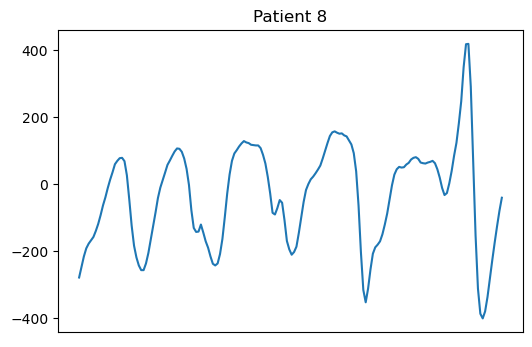

In [ ]:
figure_predID, text_predID=ppredict_with_trained_svm(svm, pca, data_norm, data, 1, 8)
figure_predID

In [ ]:
text_predID

'Prediction=1, Ground Truth=1, Probability=1.00\n\nThe patient in row 8 has a probability of 1.00 of suffering from epilepsy: further controls are suggested\n'

# GUI run

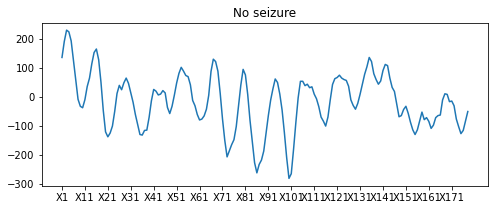

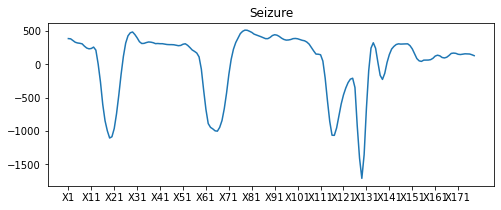

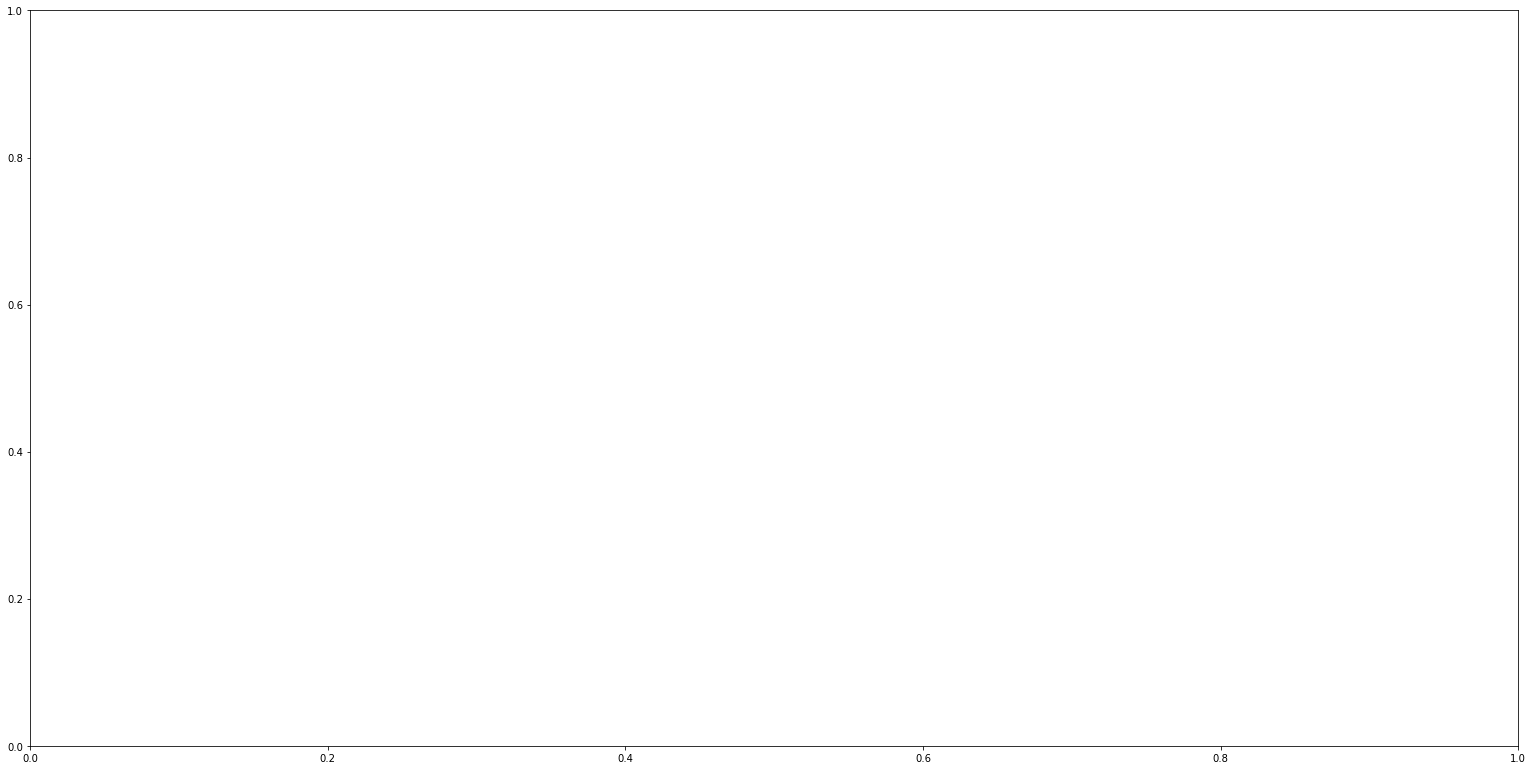

In [ ]:
root = ct.CTk()
root.title("MindWatch")
#root.configure(bg="#ADD8E6")
#my_image=ct.CTkImage(dark_image=Image.open("Enhance.png"),size=(10,10))
#button_img=ct.CTkButton(root, image=my_image)
#ct.set_default_color_theme("blue")
frame=tk.Frame(root)
frame.pack(anchor="nw")

icona1 = tk.Button(frame, bitmap="question", command=open_pdf)
icona1.pack(side=tk.LEFT, padx=(0, 5))

icona2 = tk.Button(frame, bitmap="info", command=open_inf)
icona2.pack(side=tk.LEFT)

title_label1 = ct.CTkLabel(root, text="MindWatch", font=("Helvetica", 64))
title_label1.pack(pady=30)

import_button = ct.CTkButton(root, text="Import dataset", command=import_dataset)
import_button.pack(pady=10)

dataset_label = ct.CTkLabel(root, text="")
dataset_label.pack()

run_button = ct.CTkButton(root, text="Train", state=tk.DISABLED, command=train_and_evaluate)
run_button.pack(pady=10)

plot_button = ct.CTkButton(root, text="Show examples", command=on_plot_click)
plot_button.pack()

metric_label = ct.CTkLabel(root, text="Select metric:")
metric_label.pack()

#metric_var = tk.StringVar()
metric_combobox = ct.CTkComboBox(master=root, values=["Accuracy", "Sensitivity", "Specificity"])
metric_combobox.pack()

compare_button = ct.CTkButton(root, text="Compare models", command=on_compare_click, state="disabled")
compare_button.pack(pady=10)

#label1 = ct.CTkLabel(root)
#label1.pack()

label2 = ct.CTkLabel(root, text="Insert patient ID:")
label2.pack()

entry = ct.CTkEntry(root)
entry.pack()

confirm_button = ct.CTkButton(root, text="Confirm", command=submit)
confirm_button.pack()
prediction_frame = ct.CTkFrame(root)
prediction_frame.pack(pady=10)

single_prediction_button = ct.CTkButton(prediction_frame, text="Single prediction", command=single_prediction, state="disabled")
single_prediction_button.pack(side="left", padx=10)

real_time_prediction_button = ct.CTkButton(prediction_frame, text="Real-time predictions", command=realtime_prediction, state="disabled")
real_time_prediction_button.pack(side="left", padx=10)

root.mainloop()

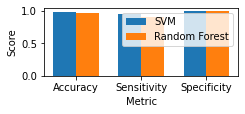

In [ ]:
#img di "compare models" button 
p1

In [ ]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,Seizure
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,15,16,12,5,-1,-18,-37,-47,-48,0
11496,-47,-11,28,77,141,211,246,240,193,136,...,-65,-33,-7,14,27,48,77,117,170,1
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,0
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,121,135,148,143,116,86,68,59,55,0


In [ ]:
data_norm

array([[ 0.88505134,  1.20992878,  1.46276429, ..., -0.63414367,
        -0.43329036, -0.23539922],
       [ 2.40057718,  2.36619038,  2.23944096, ...,  1.02342937,
         0.95424076,  0.85653664],
       [-0.12328657, -0.16915405, -0.22513147, ..., -0.13687176,
        -0.13859348, -0.14440456],
       ...,
       [ 0.1544592 ,  0.10184476, -0.01720228, ...,  0.0657205 ,
         0.07015014,  0.02545213],
       [-0.17159018, -0.08484331,  0.00725997, ...,  0.49546166,
         0.43852123,  0.40762968],
       [ 0.24502848,  0.31262161,  0.41088722, ...,  0.0657205 ,
         0.08856869,  0.19530882]])